# SIV PROJECT - CLASSIFICATION OF SHIP FROM SAR IMAGES

## PROBLEM PRESENTATION



## PRE-PROCESSING PHASE


In [108]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os 
import random
import glob
import zipfile

Here we define some utility functions that will be used in the notebook.

In [109]:
from skimage import img_as_float

# Show multiple images
def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        cmap='gray' if len(img.shape) == 2 else None
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(label)

# function to take a random file from the folder and applying canny transformation
def get_random_jpg_file(jpg_files):
    if not jpg_files:
        print("No jpg files found in the folder.")
        return None

    random_jpg = random.choice(jpg_files)

    return os.path.join(random_jpg)

def unzip_dir(dir):
    if not os.path.exists(dir):    
        with zipfile.ZipFile(f'{dir[:-1]}.zip', 'r') as zip_ref:
            zip_ref.extractall('./')
    else:
        print("The directory already exists.")

## SAR Images Dataset
Description about dataset and images.
The dataset size is 39729.

The directory already exists.
The dataset contains 39729 images.


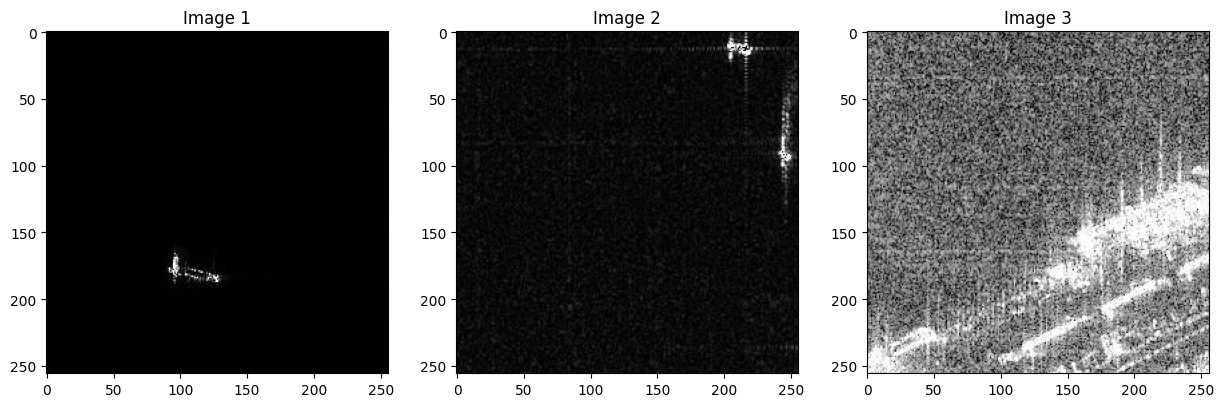

In [116]:
BASE_DIR = './ship_dataset_v0/'

unzip_dir(BASE_DIR)

# Replace 'path/to/directory' with the directory path where your .jpg files are located
jpg_files = glob.glob(BASE_DIR +'*.jpg')
print(f'The dataset contains {len(jpg_files)} images.')

# Display n random images from the dataset
# TODO: show also the txt files

# display n images from jpg_files randomly or not
def display_images(jpg_files, n_times, rand=True):
    if not jpg_files:
        print("There are not images to display.")
        return
    
    images = []
    titles = []

    for i in range(n_times):
        if rand:
            img = get_random_jpg_file(jpg_files)
        else:
            img = jpg_files[i]
        if isinstance(img, str):
            img = cv2.imread(img)
        
        title = f'Image {i+1}'
        images.append(img)
        titles.append(title)
        
    imshow_all(*images, titles=titles)

display_images(jpg_files, 3)

Here we show images with the purpose to analize the following problems related to the project:
* ***Speckle noise:*** a type of multiplicative noise which appears due to the variation in the backscatter from non-homogeneous cells which gives a grainy appearance to SAR images.

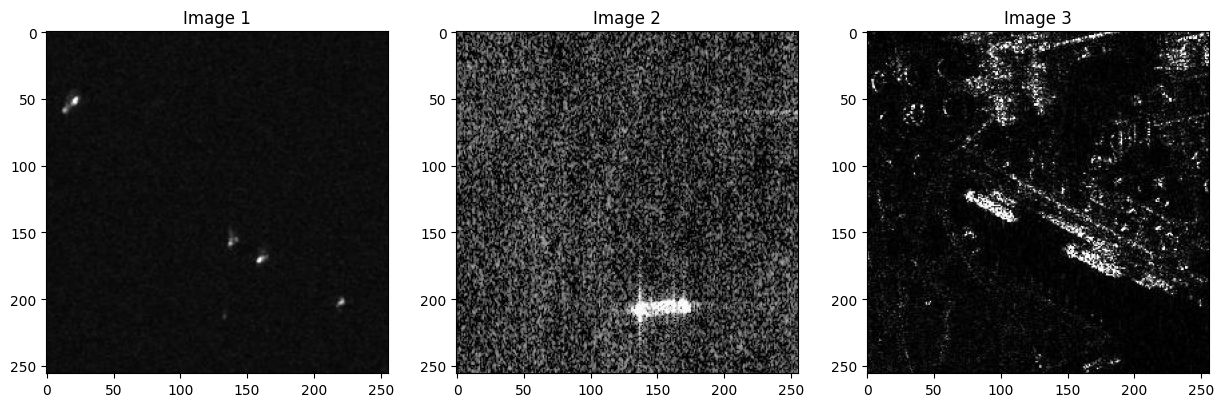

In [117]:
images = [
    BASE_DIR + 'ship030608' + '.jpg',
    BASE_DIR + 'Gao_ship_hh_020170901300405023' + '.jpg',
    BASE_DIR + 'Sen_ship_hv_020161127030704' + '.jpg'
]

display_images(images, len(images), rand=False)

We now take a random image as example to test different image processing techniques and try to improve the quality of the images.
Since the color is not relevant in the image, we convert it to grayscale to reduce the channels from 3 to 1 for an easier computation.

Image file name: ./ship_dataset_v0\Sen_ship_hv_0201705190105304.jpg
Each image is 256 rows x 256 cols of pixels
The original image has 3 channels: (256, 256, 3)
The grayscale version of the image has only 1 channel: (256, 256)

 ./ship_dataset_v0\Sen_ship_hv_0201705190105304.txt
Contents of the file:
0 0.3515625 0.767578125 0.2109375 0.09765625
0 0.697265625 0.80078125 0.18359375 0.09375

The ships in the file are 2


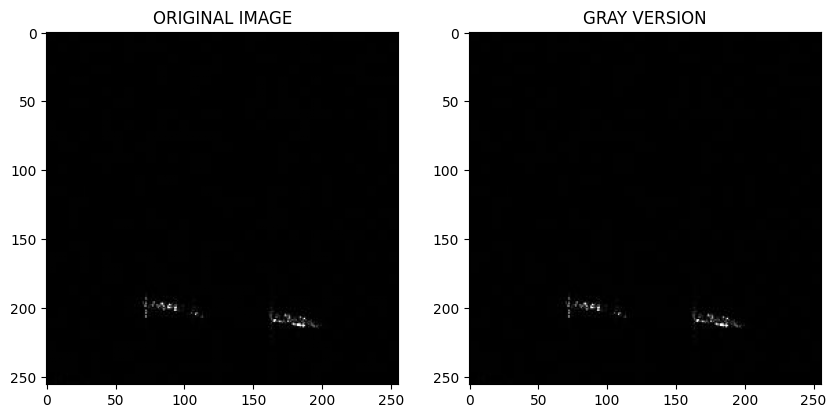

In [118]:
file_jpg = get_random_jpg_file(jpg_files)
print(f'Image file name: {file_jpg}')
img = cv2.imread(file_jpg)
print(f'Each image is {img.shape[0]} rows x {img.shape[1]} cols of pixels')
print(f'The original image has 3 channels: {img.shape}')

# convert the image to grayscale to remove useless channels (from 3 to 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(f'The grayscale version of the image has only 1 channel: {gray.shape}')

# analize the text file
file_txt = file_jpg[:-3] + 'txt'
print('\n', file_txt)
ships_cnt = 0
with open(file_txt, 'r') as file:
    file_content = file.read()
    print("Contents of the file:")
    print(file_content)
    ships_cnt = len(file_content.splitlines())
    print(f'The ships in the file are {ships_cnt}')

imshow_all(img, gray, titles=["ORIGINAL IMAGE", "GRAY VERSION"])

Here we show the histogram of the image.

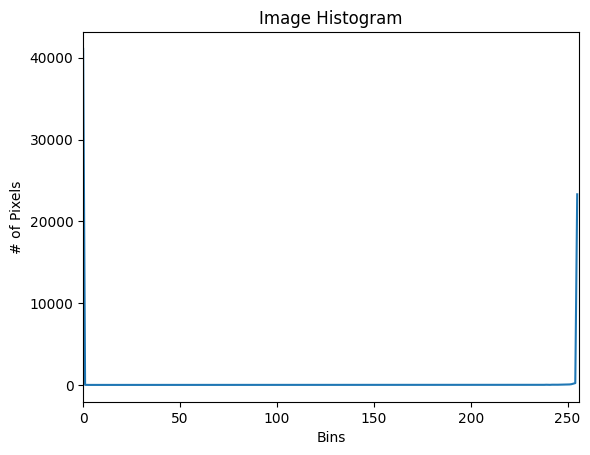

In [119]:
# function to compute and plot the histogram of a grayscale image
def grayscale_histogram(img, title=""):
    img = np.uint8(img * 255)
    histogram = cv2.calcHist([img], [0], None, [256], [0, 256])

    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(histogram)
    plt.xlim([0, 256])
    plt.show()

grayscale_histogram(gray, title="Image Histogram")

## SAR Image Processing Techniques

## Denoising

The pre-processing techniques of SAR images have been broadly put under following two categories: ***Frequency Domain Filtering*** and ***Spatial Filtering***.

Under spacial filtering we have the following techniques:
* Contrast Stretching
* Noise filtering
* Histogram modification

Under frequency domain filering we have:
* Fast Fourier Transform
* Wavelet Transform

### Non-Local Means Filter

We try the Non-Local Means Filter using 2 different patch size. A lowest patch size keep details while a higher one remove more noise. We plot both results to compare which is best for 2 different images with different levels of noise.

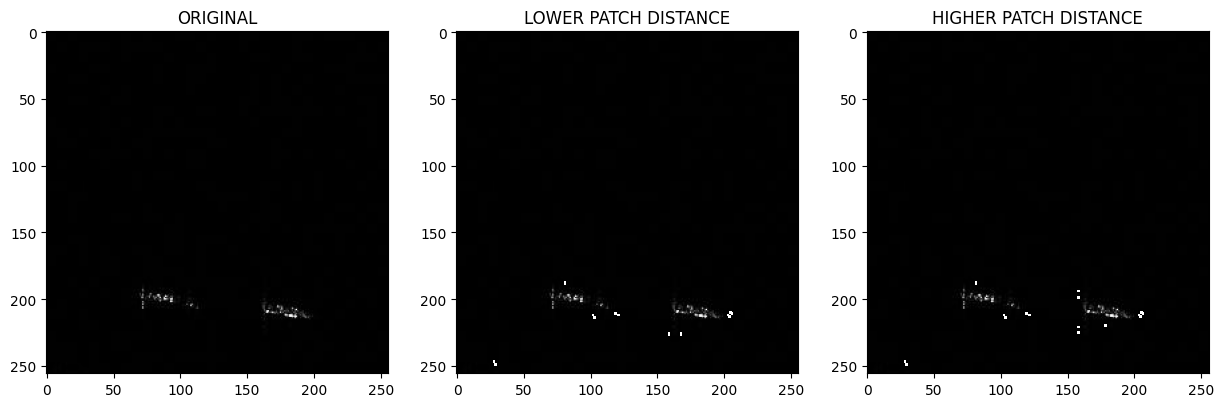

In [120]:
from skimage.restoration import denoise_nl_means, estimate_sigma

def nl_means_compare(img):
    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    # Non-Local Means Denoising technique with lower patch distance
    nl_means_lower = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=3, channel_axis=None)
    # Non-Local Means Denoising technique with higher patch distance
    nl_means_higher = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=6, channel_axis=None)
    imshow_all(img, nl_means_lower, nl_means_higher, titles=["ORIGINAL", "LOWER PATCH DISTANCE", "HIGHER PATCH DISTANCE"])

def nl_means_filter(img, k_size=5):
    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    nl_means = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=6, channel_axis=None)

    # apply Gaussian blur to remove non speckle noise
    nl_means = np.uint8(nl_means * 255)
    blurred_img = cv2.GaussianBlur(nl_means, (k_size, k_size), 0)

    return blurred_img

# Convert the image to float data type
img = gray.astype(np.float64) / 255.0

# less_noise = BASE_DIR + 'ship030608' + '.jpg'
# more_noise = BASE_DIR + 'Gao_ship_hh_020170901300405023' + '.jpg'
# less_noise_img = cv2.imread(less_noise, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
# more_noise_img = cv2.imread(more_noise, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0

nl_means_compare(img)
# nl_means_compare(less_noise_img)
# nl_means_compare(more_noise_img)

nl_means_img = nl_means_filter(img)

### Wavelet Filter

We now apply the Wavelet filter plus Gaussian blur.

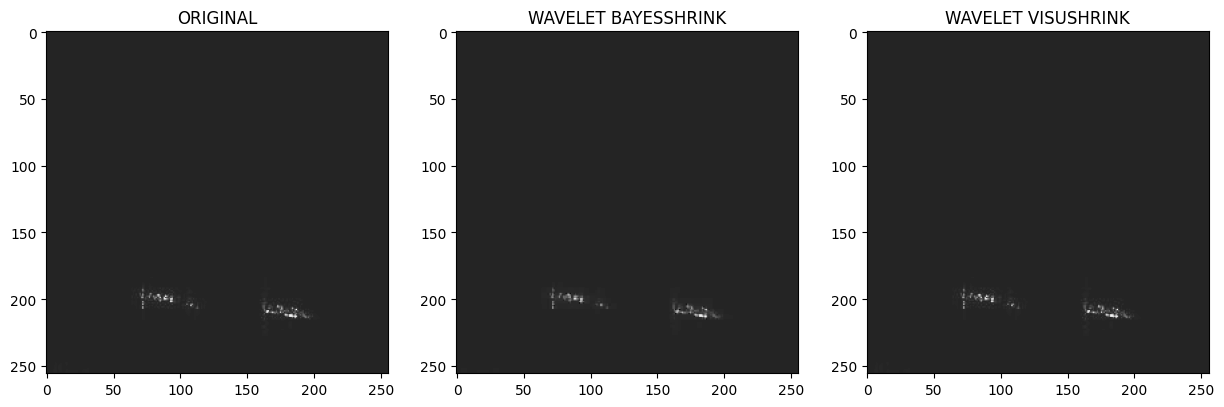

In [121]:
from skimage.restoration import denoise_wavelet

def wavelet_compare(img):
    # Estimate the average noise standard deviation across color channels.
    sigma_est = estimate_sigma(img, channel_axis=None, average_sigmas=True)
    # Wavelet Denoising BayesShrink approach
    img_bayes = denoise_wavelet(img, channel_axis=None, method='BayesShrink', mode='soft', rescale_sigma=True)
    # Wavelet Denoising VisuShrink approach
    img_visushrink = denoise_wavelet(img, channel_axis=None, method='VisuShrink', mode='soft', 
                                    sigma=sigma_est, rescale_sigma=True)
    imshow_all(img, img_bayes, img_visushrink, titles=["ORIGINAL", "WAVELET BAYESSHRINK", "WAVELET VISUSHRINK"])

def wavelet_filter(img, k_size=5):
    img_bayes = denoise_wavelet(img, channel_axis=None, method='BayesShrink', mode='soft', rescale_sigma=True)

    # apply Gaussian blur to remove non speckle noise
    img_bayes = np.uint8(img_bayes * 255)
    blurred_img = cv2.GaussianBlur(img_bayes, (k_size, k_size), 0)

    return blurred_img

wavelet_compare(img)
# wavelet_compare(less_noise_img)
# wavelet_compare(more_noise_img)

wavelet_img = wavelet_filter(img)

### Lee Filter

Formula: https://www.imageeprocessing.com/2014/08/lee-filter.html

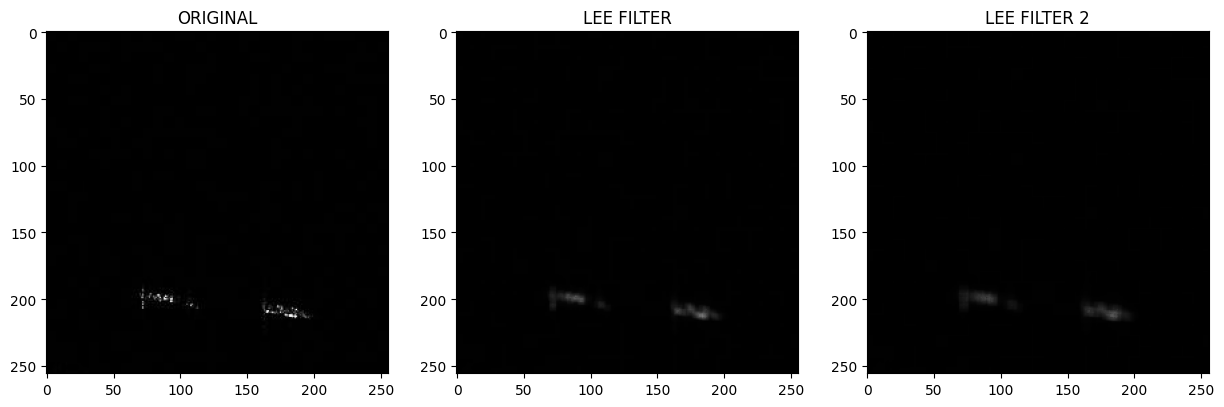

In [122]:
def lee_filter(img, window_size=5, k=1.0):

    radius = window_size // 2
    padded_img = np.pad(img, radius, mode='reflect')    
    filtered_img = np.zeros_like(img)

    for i in range(radius, padded_img.shape[0] - radius):
        for j in range(radius, padded_img.shape[1] - radius):
            local_window = padded_img[i - radius:i + radius + 1, j - radius:j + radius + 1]
            local_mean = np.mean(local_window)
            local_var = np.var(local_window)
            weight = local_var / (local_var + k**2)

            filtered_img[i - radius, j - radius] = local_mean + weight * (img[i - radius, j - radius] - local_mean)
            
    filtered_img = np.uint8(filtered_img * 255)
    return filtered_img

lee_img = lee_filter(img)
lee_img2 = lee_filter(img, window_size=7)

imshow_all(img, lee_img, lee_img2, titles=["ORIGINAL", "LEE FILTER", "LEE FILTER 2"])

### Frost Filter

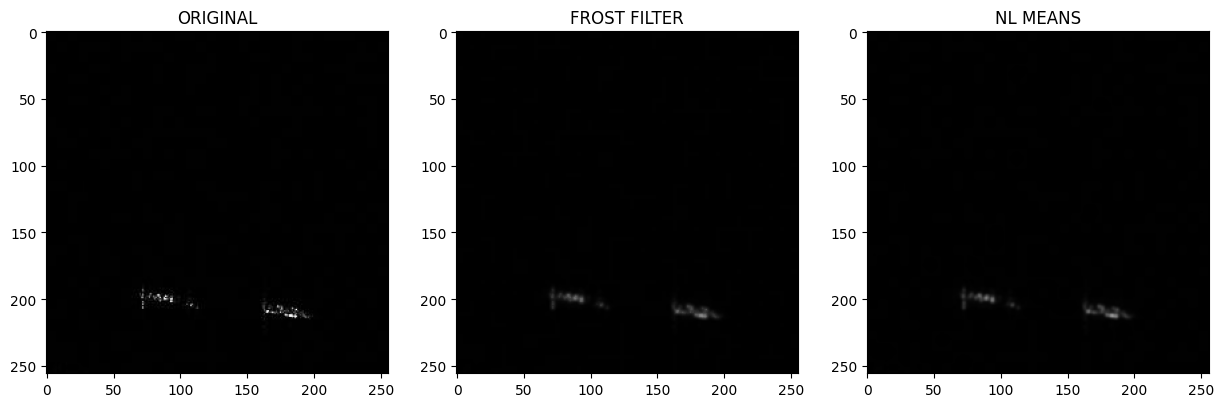

In [123]:
def frost_filter(img, window_size=5, damping_factor=1.0):
    
    radius = window_size // 2
    padded_img = np.pad(img, radius, mode='reflect')
    filtered_img = np.zeros_like(img)

    for i in range(radius, padded_img.shape[0] - radius):
        for j in range(radius, padded_img.shape[1] - radius):

            local_window = padded_img[i - radius:i + radius + 1, j - radius:j + radius + 1]

            local_mean = np.mean(local_window)
            local_var = np.var(local_window)

            distances = np.sqrt((np.arange(window_size) - radius)[:, None]**2 + (np.arange(window_size) - radius)**2)
            weights = np.exp(-distances / (local_var + damping_factor))
            weights /= np.sum(weights)

            filtered_img[i - radius, j - radius] = np.sum(local_window * weights)

    filtered_img = np.uint8(filtered_img * 255)
    return filtered_img

frost_img = frost_filter(img)
imshow_all(img, frost_img, nl_means_img, titles=["ORIGINAL", "FROST FILTER", "NL MEANS"])

We now compare the results of the previous filter methods.

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


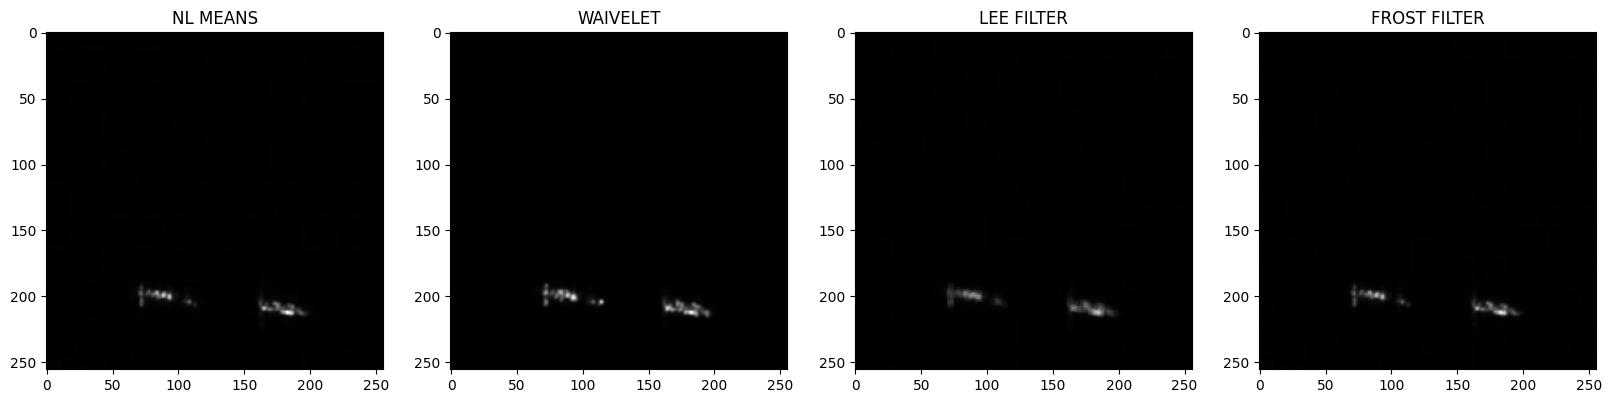

In [124]:
for img in [nl_means_img, wavelet_img, lee_img, frost_img]:
    print(img)

imshow_all(nl_means_img, wavelet_img, lee_img, frost_img, titles=["NL MEANS", "WAVELET", "LEE FILTER", "FROST FILTER"])

## Contrast Enhancement

We enhance the images to improve the visibility of features of interest, such as the ships.

### Contrast Limited Adaptive Histogram Equalization (CLAHE)

The histogram mean is 19.805572509765625


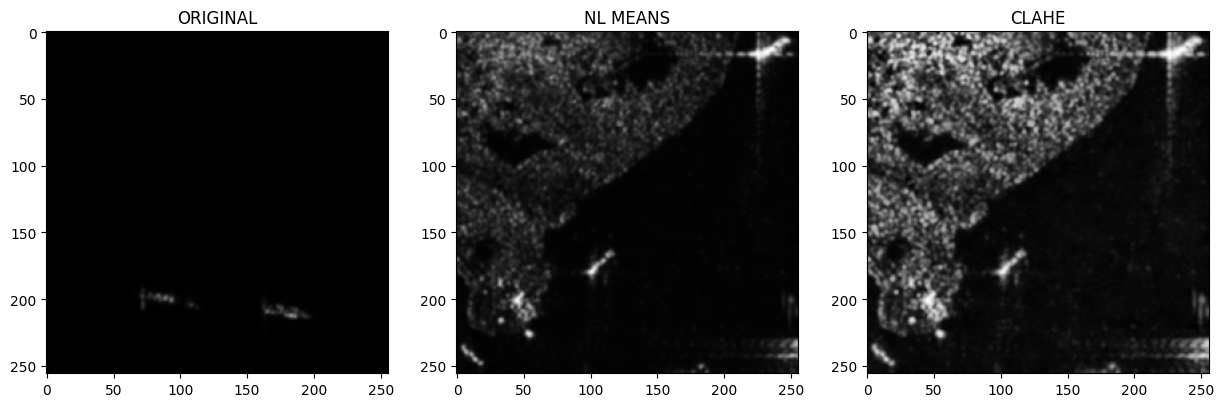

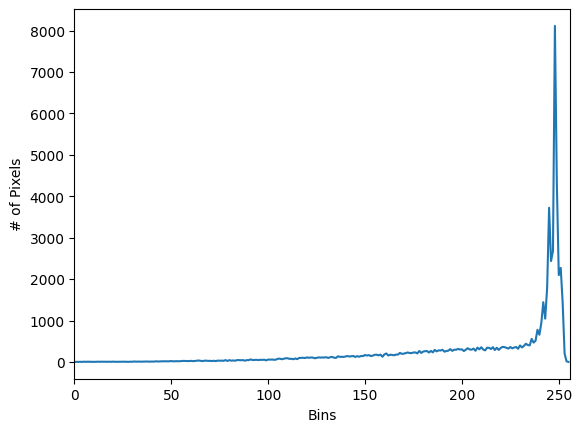

In [125]:
def clahe(img):
    # img = np.uint8(img * 255)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    # Calculate the weighted mean of the histogram to find the average brightness
    brightness_average = np.sum(hist * np.arange(256).reshape(256, 1)) / np.sum(hist)
    print(f"The histogram mean is {brightness_average}")
    brightness_threshold = 128

    # enhance the image only if it is considered a dark image
    if brightness_average >= brightness_threshold:
        print("The image is already light.")
        return img
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img_clahe = clahe.apply(img)
    return enhanced_img_clahe

clahe_img = clahe(nl_means_img)
imshow_all(img, nl_means_img, clahe_img, titles=["ORIGINAL", "NL MEANS", "CLAHE"])
grayscale_histogram(clahe_img)

## Edge Detection

There are 2 in the image.


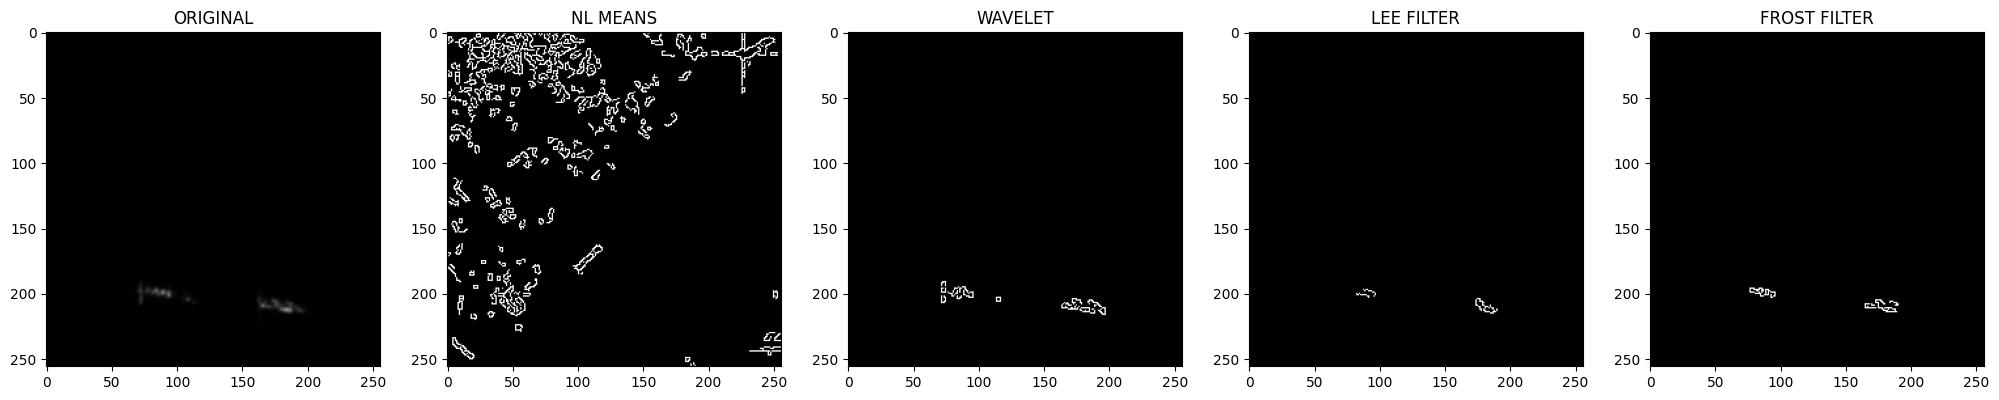

In [126]:
def canny(img):
    # img = np.uint8(img * 255)
    canny_img = cv2.Canny(img, threshold1=100, threshold2=200)
    return canny_img

nl_means_canny = canny(nl_means_img)
wavelet_canny = canny(wavelet_img)
lee_canny = canny(lee_img)
frost_canny = canny(frost_img)

print(f"There are {ships_cnt} in the image.")

imshow_all(img, nl_means_canny, wavelet_canny, lee_canny, frost_canny, titles=["ORIGINAL", "NL MEANS", "WAVELET", "LEE FILTER", "FROST FILTER"])

## Image Segmentation

There are 2 in the image.


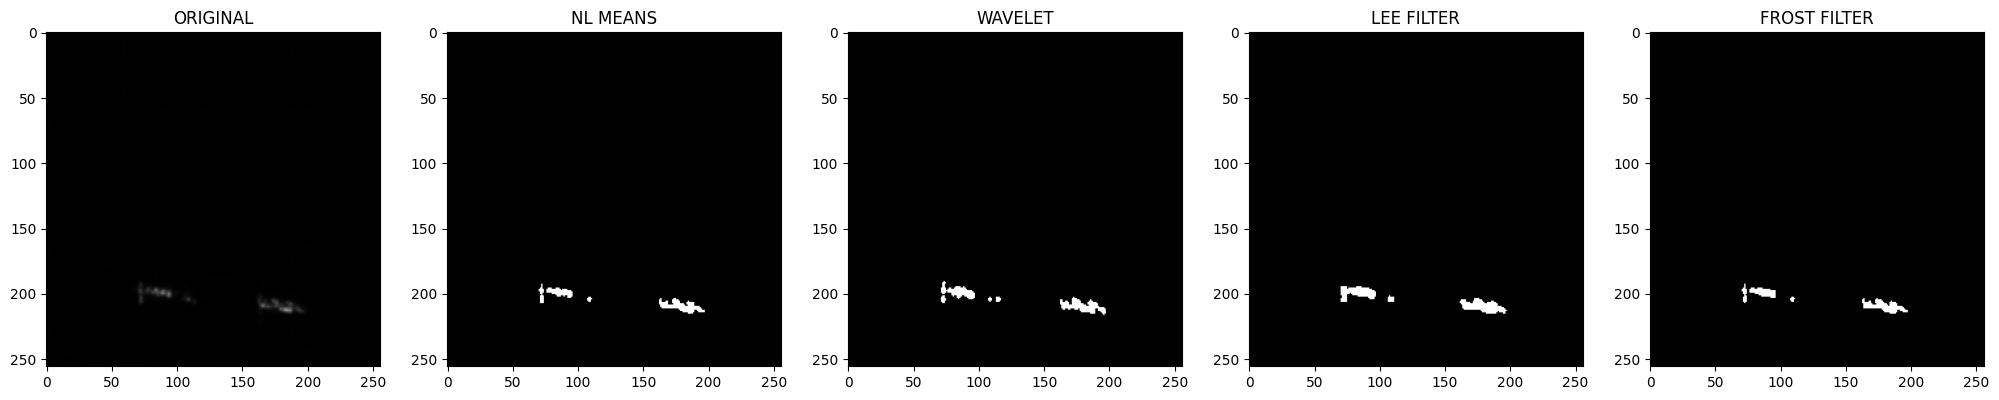

In [127]:
# Apply global thresholding using Otsu's method
def thresholding(img):
    # img = np.uint8(img * 255)
    _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_img

thresholded_nl_means = thresholding(nl_means_img)
thresholded_wavelet = thresholding(wavelet_img)
thresholded_lee = thresholding(lee_img)
thresholded_frost = thresholding(frost_img)

print(f"There are {ships_cnt} in the image.")

imshow_all(img, thresholded_nl_means, thresholded_wavelet, thresholded_lee, thresholded_frost, 
           titles=["ORIGINAL", "NL MEANS", "WAVELET", "LEE FILTER", "FROST FILTER"])

## Normalization

Check new generated images and apply normalization techniques if needed.

In [128]:
def analize_img(img, title=""):
    max = img.max()
    min = img.min()
    print(f"{title}:\n", f"min value: {min}\n", f"max value: {max}\n")
    print(img)

# analize_img(nl_means_img, "nl means")
# analize_img(wavelet_img, "wavelet")
# analize_img(lee_img, "lee filter")
# analize_img(frost_img, "frost filter")

## Dataset Pre-processing

We apply the pre-processing to every image of the dataset.

In [129]:
import shutil

def preprocess_images(jpg_files, filter, dir_name):
    output_directory = './' + dir_name + '/'
    if os.path.isdir(output_directory):
        shutil.rmtree(output_directory)
    os.makedirs(output_directory, exist_ok=False)

    for jpg_file in jpg_files:
        img = cv2.imread(jpg_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        float_img = gray.astype(np.float64) / 255.0
        new_img = filter(float_img)

        # TODO: add also text files
        output_path = os.path.join(output_directory, f"segmented_{os.path.basename(jpg_file)}")
        cv2.imwrite(output_path, new_img)

preprocess_images(jpg_files, lee_filter, 'ship_dataset_leefilter')
# preprocess_images(jpg_files, frost_filter, 'ship_dataset_frostfilter')
# display_images(new_jpgs, 3)

KeyboardInterrupt: 

Zipping the new images folder.

In [52]:
def zip_folder(folder_path, zip_path):
    if not os.path.exists(folder_path):
        print("The folder path doesn't exist.")
        return

    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, folder_path)
                zip_file.write(file_path, arc_name)

folder = './ship_dataset_preprocessed/'

# all images inside, no folder
zip_folder(folder, folder[:-1]+'.zip')

## Other

(256, 256, 3)


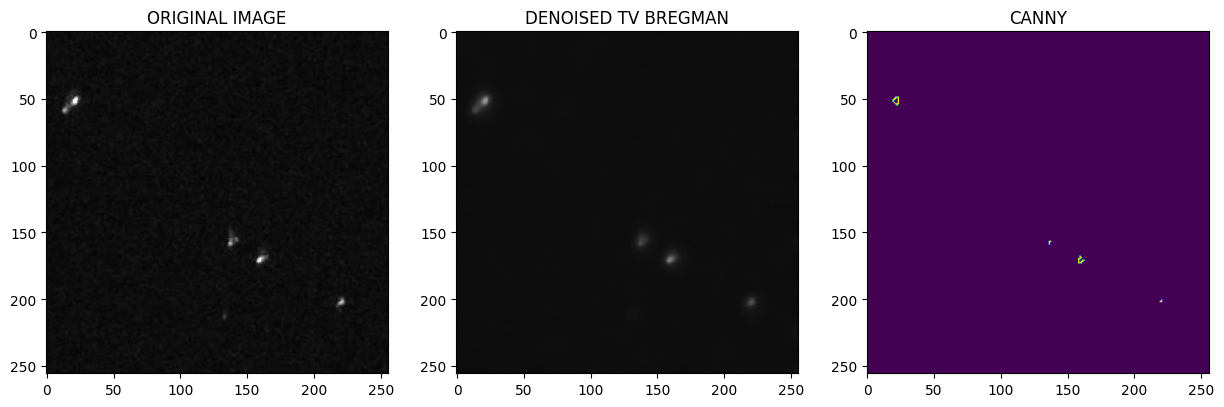

In [5]:
# other denoise filters

from skimage.restoration import denoise_tv_bregman
from skimage.morphology import disk
example_image = img
denoised = denoise_tv_bregman(example_image, 1)
d = disk(4)
#median = filters.rank.median(example_image, d)
titles = ['image', 'denoised', 'canny']

#canny
edges = cv2.Canny(example_image,600
                  ,750)

print(denoised.shape)

imshow_all(example_image, denoised, edges, titles=["ORIGINAL IMAGE",  "DENOISED TV BREGMAN", "CANNY"])





Random JPG file selected: ./ship_dataset_v0\Sen_ship_hh_02016092801054018.jpg
./ship_dataset_v0\Sen_ship_hh_02016092801054018.txt
Contents of the file:
0 0.869140625 0.748046875 0.19921875 0.20703125

(256, 256, 3)
['./ship_dataset_v0\\Sen_ship_hh_02016092801054018.jpg', 'denoised', 'canny']
Random JPG file selected: ./ship_dataset_v0\Gao_ship_hh_020170215800101109.jpg
./ship_dataset_v0\Gao_ship_hh_020170215800101109.txt
Contents of the file:
0 0.62890625 0.111328125 0.1015625 0.06640625
0 0.673828125 0.67578125 0.14453125 0.1484375
0 0.5234375 0.865234375 0.140625 0.13671875
0 0.83984375 0.509765625 0.125 0.12109375

(256, 256, 3)
['./ship_dataset_v0\\Gao_ship_hh_020170215800101109.jpg', 'denoised', 'canny']


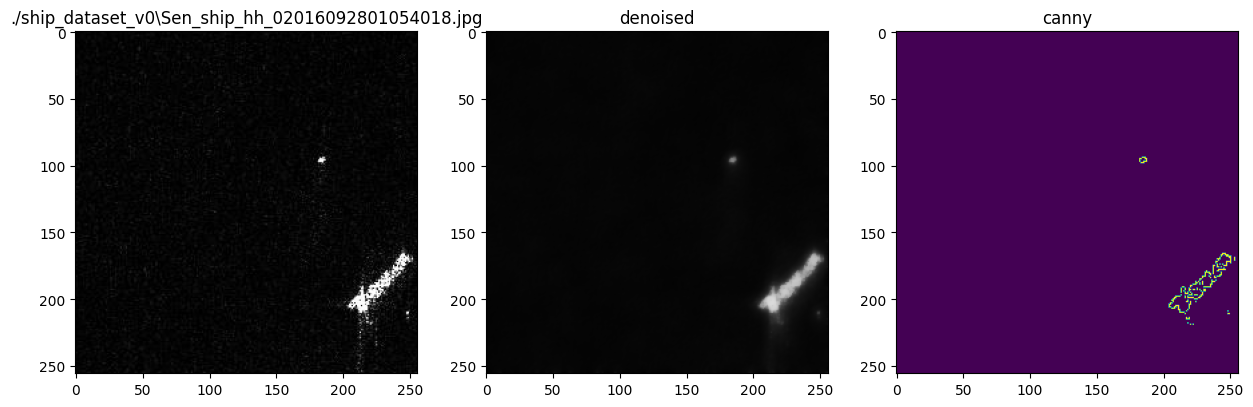

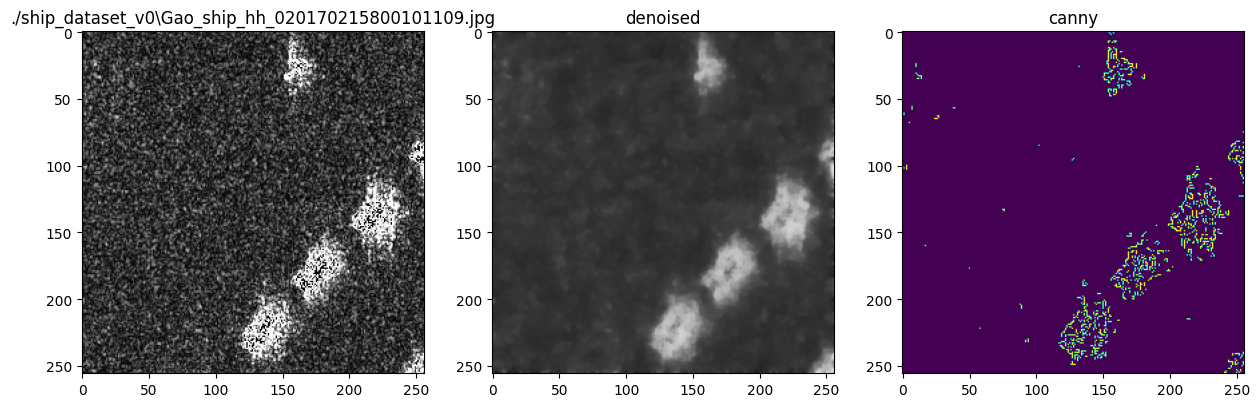

In [19]:
n_times = 2

for i in range(0, n_times):
    random_jpg_file = get_random_jpg_file()

    if random_jpg_file:
        print(f"Random JPG file selected: {random_jpg_file}")

        txt_file = random_jpg_file.replace(".jpg", ".txt")
        print(txt_file)
        with open(txt_file, 'r') as file:
            file_content = file.read()
            print("Contents of the file:")
            print(file_content)

        image=cv2.imread(random_jpg_file)
        denoised = denoise_tv_bregman(image, 1)
        d = disk(4)
        #median = filters.rank.median(example_image, d)
        titles = [random_jpg_file, 'denoised', 'canny']


        #canny
        # this parameters can be modified we have problems when we are dealing with a harbour and coastal areas 
        edges = cv2.Canny(image,600,750)

        print(denoised.shape)

        print(titles)
        imshow_all(image, denoised, edges, titles=titles)

In [8]:
'''
img = cv2.imread('./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg')
dst = cv2.fastNlMeansDenoising(img, None, 10)

# convert to gray
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# blur
#smooth = cv2.GaussianBlur(gray, (8,8), 0)

# smooth with bilateral filter to remove noise 
# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
smooth = cv2.bilateralFilter(img, 50, 200, 200)
# divide gray by morphology image
#division = cv2.divide(gray, smooth, scale=255)

canny_before = cv2.Canny(gray, 600, 750)
canny = cv2.Canny(smooth, 600, 750)

#sharp = filters.unsharp_mask(division, radius=1.5, amount=1.5, multichannel=False, preserve_range=False)
#sharp = (255*sharp).clip(0,255).astype(np.uint8)
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

test = denoise_bilateral(img, sigma_color=0.50, sigma_spatial=10,
                channel_axis=-1)

# TODO: try to use the canny on the test image
canny_on_test = cv2.Canny(test, 600, 750)
imshow_all(img, canny_before, dst, smooth, canny, canny_on_test)




#plt.subplot(154),plt.imshow(division)
#plt.subplot(155),plt.imshow(sharp)

plt.show()
'''

"\nimg = cv2.imread('./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg')\ndst = cv2.fastNlMeansDenoising(img, None, 10)\n\n# convert to gray\ngray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)\n# blur\n#smooth = cv2.GaussianBlur(gray, (8,8), 0)\n\n# smooth with bilateral filter to remove noise \n# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed\nsmooth = cv2.bilateralFilter(img, 50, 200, 200)\n# divide gray by morphology image\n#division = cv2.divide(gray, smooth, scale=255)\n\ncanny_before = cv2.Canny(gray, 600, 750)\ncanny = cv2.Canny(smooth, 600, 750)\n\n#sharp = filters.unsharp_mask(division, radius=1.5, amount=1.5, multichannel=False, preserve_range=False)\n#sharp = (255*sharp).clip(0,255).astype(np.uint8)\nfrom skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,\n                                 denoise_wavelet, estimate_sigma)\n\ntest = denoise_bilateral(img, sigma_color=0.50, sigma_spatial=10,\n                chann

In [9]:
# TODO: given the latter we need to asses when the bilater filter is actually necessary and when it is not
# so we need to respond actually to this question: when we can define an image noisy?

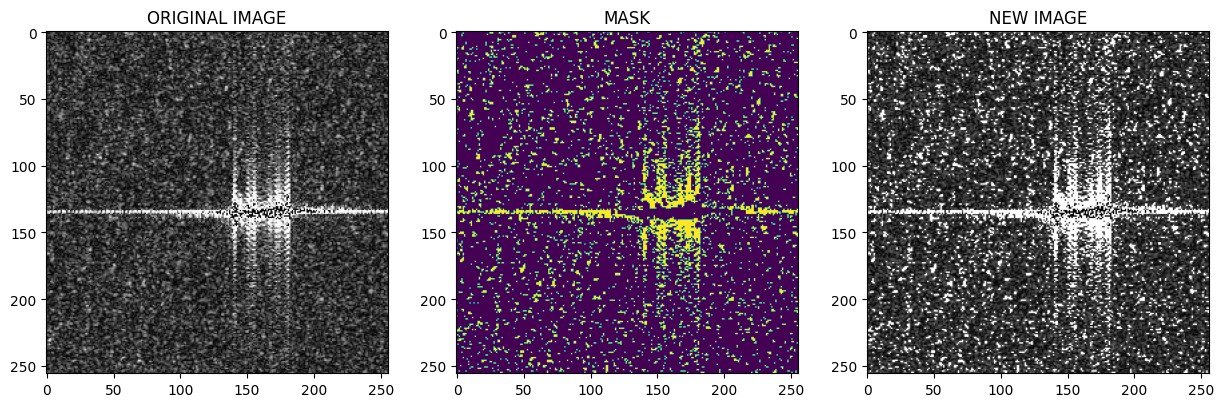

In [10]:
def test_remove_gray (img_path = "./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg"):

    img = cv2.imread(img_path)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsv, (0, 0, 100), (255, 5, 255))
    #cv2.imshow('mask before and with nzmask', mask);

    # Build mask of non black pixels.
    nzmask = cv2.inRange(hsv, (0, 0, 5), (255, 255, 255))

    # Erode the mask - all pixels around a black pixels should not be masked.
    nzmask = cv2.erode(nzmask, np.ones((3,3)))
    #cv2.imshow('nzmask', nzmask);

    mask = mask & nzmask

    new_img = img.copy()
    new_img[np.where(mask)] = 255
    return mask, new_img

mask, new_img = test_remove_gray()

imshow_all(cv2.imread("./ship_dataset_v0/Gao_ship_hh_020170405960306013.jpg"), mask, new_img, titles=["ORIGINAL IMAGE", "MASK", "NEW IMAGE"])

## CNN / Mask R-CNN / Faster R-CNN with object detection

In order to perform the detection after the pre-processing phase we are going to use the images to train a model and compute where the ship are inside the image.
In the final part we will discuss about the result of the CNN comparing the result using the two training dataset (the pre-processed one and the original dataset) to see if the behaviour of the NN changes.

TODO: maybe do a comparison between a YOLO, RetinaNet and Faster R-CNN

Rotatable boxes are used in order to have a better AP with CNN

MS COCO : 

mAP (mean Average Precision): comprehensive evaluation on ship detection and
instance segmentation

$$IoU  = \int \nabla u \cdot \nabla v~dx = \int_\Omega fv~dx


IoUmask =
Maskpd ∩ Maskgt
Maskpd ∪ Maskgt
$$




$$IoU_{mask} = \frac{Mask_{pd} \cup  Mask_{gt}}{Mask_{pd} \cap Mask_{gt}}

$$

In [99]:
# Function for verifying the ground truth of a given image

def verify_ground_truth(img_name):
    img = cv2.imread(BASE_DIR)
    # TODO

def get_bound_box(img_name):
    txt_file = img_name+".txt"
    #print(txt_file)
    try:
        with open(txt_file, 'r') as file:
            file_content = file.read()
            #print("Contents of the file:")

            # now we convert the actual string in a list of float
            #print("\nAfter the conversion:\n")
            a = list(map(float, file_content.split()))
            #print(type(a))
            #print(a)
    except FileNotFoundError:
        print("File not found or path is incorrect")

    return a

def visualize_bound_box(img_name = "not provided"):
    if img_name == "not provided":
        img_name = get_random_file()
    else:
        img_name = BASE_DIR+img_name

    bounds = multiply_array(get_bound_box(img_name), 256)
    #print(bounds)

    img = cv2.imread(img_name+".jpg")

    assert len(bounds)%5 == 0, "Incomplete bound length"

    for i in range(0, len(bounds), 5):
        category = bounds[i]
        x = bounds[i+1]
        y = bounds[i+2]
        w = bounds[i+3]
        h = bounds[i+4]

        x1 = int(x - w/2)
        y1 = int(y - h/2)
        x2 = int(x + w/2)
        y2 = int(y + h/2)

        #print(f"Category: {category}")
        #print(f"X: {x}")
        #print(f"Y: {y}")
        #print(f"W: {w}")
        #print(f"H: {h}")
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def multiply_array(arr, num):
    return [i * num  if (index % 5 != 0) else i for index, i in enumerate(arr)]
# Category of the ship
# normalized column value of the ship center in the chip
# normalized row value of the ship center
# normalized ship width 
# normalized ship length.
# EXAMPLE
# [0.0, 0.63671875, 0.52734375, 0.2109375, 0.0546875]

# this has more than one ship
#get_bound_box('Gao_ship_hh_02016082544040403')
#print_bound_box('Gao_ship_hh_02016082544040403')

def get_random_file():
    jpg_file = get_random_jpg_file()
    random_file = jpg_file.replace(".jpg", "")
    return random_file

# without parameters you will get a random image
visualize_bound_box()

# you can add the file name in order to select a specific image
# visualize_bound_box("Gao_ship_hh_02016082544040302")



## RESULTS


## *Resources*

* OpenCV documentation: https://docs.opencv.org/4.x/
* Scikit-image documentation: https://scikit-image.org/docs/stable/
* P. Kaushik and S. Jabin, "A Comparative study of Pre-processing Techniques of SAR Images," 2018 4th International Conference on Computing Communication and Automation (ICCCA), Greater Noida, India, 2018, pp. 1-4, doi: 10.1109/CCAA.2018.8777710.